In [2]:
import qrcode
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
protein = pd.read_csv('../db_tables/protein.tsv', sep= '\t')

In [4]:
# qr code for MLOs
img = qrcode.make('http://mlos.leloir.org.ar/#/')
img.save('../plots/mlos_metadb_qr.png')

# Proteins and roles

In [5]:
rol = pd.read_csv("../db_tables/rol.tsv", sep= "\t")
mlo = pd.read_csv("../db_tables/mlo.tsv", sep= "\t")
dataset = pd.read_csv("../db_tables/dataset.tsv", sep= "\t")
protein_has_mlo = pd.read_csv("../db_tables/protein_has_mlo.tsv", sep= "\t").merge(rol, how='left').merge(mlo, how='left').merge(dataset, how='left')
protein_has_mlo.drop(
    columns = ['id_mlo', 'id_rol', 'id_dataset'],
    inplace= True
)

In [6]:
protein_has_mlo.rol.fillna("unassigned", inplace= True)
protein_has_mlo

,reviewed,id_protein,id_proteinmlo,rol,mlo,dataset
0,lt,1,1,driver,cytoplasmic stress granule,phasepro
1,NaN,1,2,driver,Gemini of cajal body,drllps
2,NaN,1,3,driver,Nuclear speckle,drllps
3,NaN,1,4,driver,Nucleolus,drllps
4,NaN,1,5,driver,Paraspeckle,drllps
...,...,...,...,...,...,...
11514,ht,5739,11515,unassigned,Nucleolus,phasepdb
11515,ht,5740,11516,unassigned,Nucleolus,phasepdb
11516,ht,5740,11517,unassigned,Nuclear speckle,phasepdb
11517,NaN,5741,11518,client,Nucleolus,drllps


In [7]:
protein_has_mlo.rol.isna().any()

False

In [8]:
protein_has_mlo.rol.value_counts()

unassigned    6025
client        4138
driver         716
regulator      640
Name: rol, dtype: int64

In [9]:

roles = protein_has_mlo.rol.value_counts()
roles_b = protein_has_mlo[['id_protein', 'rol']].drop_duplicates().fillna("unassigned").rol.value_counts(dropna= False)
roles_b
# invierto el orden
roles_b = roles_b.iloc[::-1]
roles_b

driver         285
regulator      357
client        3175
unassigned    4105
Name: rol, dtype: int64

In [57]:
roles_b

Drivers        285
Clients       3175
Regulators     357
Unknown       4105
Name: rol, dtype: int64

In [11]:
order = ['driver', 'client', 'regulator', 'unassigned']

In [12]:
roles_b = roles_b.reindex(order)

{'driver': "#597dbf", 
'client':"#75bf70", 
'regulator': "#c86e6e",
na':'#c7c7c7'}

In [32]:
roles_b.rename({'driver':'Drivers', 'client':'Clients', 'regulator': 'Regulators', 'unassigned': 'Unknown'}, inplace= True)

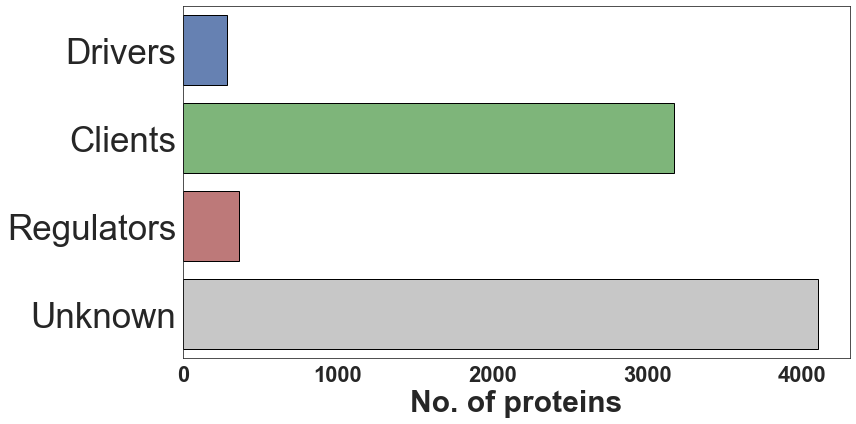

In [41]:
sns.set_style("white")
#sns.set_palette('turbo', 10)

bar,ax1 = plt.subplots(figsize=(12,6))

colors = ["#597dbf","#75bf70", "#c86e6e", '#c7c7c7']
ax1 = sns.barplot(x= roles_b, y= roles_b.index, palette= colors, edgecolor= 'black')
#ax1.set_title("Proteins Roles\n", fontsize=25, weight='bold')
ax1.set_xlabel ("No. of proteins", fontsize=30, weight='bold')
ax1.tick_params(labelsize=35)
plt.xticks(fontsize=22, weight= 'bold')
# for i, v in enumerate(roles_b):
#     ax1.text(i, v+50, str(v),  weight='bold', fontsize= 16, ha= 'center')


patch_h = []    
for patch in bar.patches:
    reading = patch.get_height()
    print(reading)
    patch_h.append(reading) # patch_h contains the heights of all the patches now
plt.tight_layout()
plt.show()
#bar.savefig('../plots/dublin_22/protein_roles.png', dpi= 300)

In [21]:
for i, v in enumerate(roles_b):
    print(i, v)

0 285
1 3175
2 357
3 4105


In [72]:
_ = protein_has_mlo.drop_duplicates(['id_protein', 'rol']).pivot_table(index='mlo', columns=['rol'], aggfunc='size')
_['suma'] = _.apply(sum,1)
_ = _.sort_values('suma', ascending=False)
_

stacked = pd.DataFrame(_.to_records()).drop(columns=['suma']).set_index('mlo')
stacked
# rearrange columns
cols = stacked.columns.to_list()
cols = cols[1:3] + [cols[0]] + [cols[-1]]
# reorder
stacked = stacked[cols]
stacked
# Invert rows 
stacked_sub = stacked.reindex(index=stacked.index[::-1])[-8:]
stacked_sub

,driver,regulator,client,unassigned
mlo,,,,
Cajal body,2.0,10.0,23.0,68.0
Paraspeckle,3.0,1.0,18.0,150.0
PML nuclear body,6.0,21.0,49.0,117.0
Nuclear speckle,11.0,10.0,58.0,184.0
P-body,7.0,67.0,128.0,261.0
Postsynaptic density,11.0,23.0,1086.0,5.0
Stress granule,24.0,130.0,428.0,1164.0
Nucleolus,12.0,30.0,854.0,1587.0


In [76]:
cols = stacked_sub.columns.to_list()
cols

['driver', 'regulator', 'client', 'unassigned']

In [79]:
stacked_sub_prop = stacked_sub[cols].div(stacked_sub[cols].sum(axis=1), axis=0)

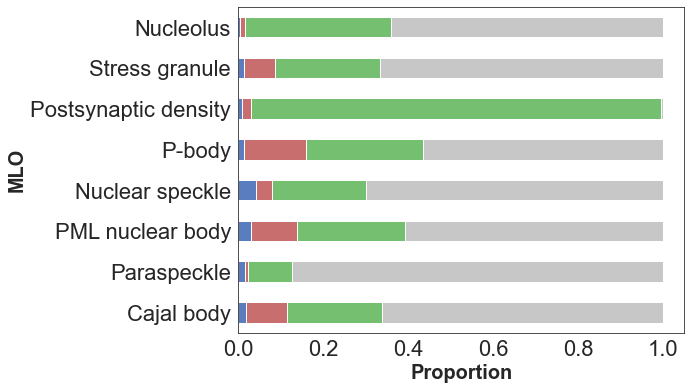

In [87]:
sns.set_style("white")
#fig, ax = plt.subplots(figsize=(12,10))
stacked_sub_prop.plot.barh(stacked=True, figsize=(8,6), color = colors)
#stacked[:20].plot(kind='bar', stacked=True)
plt.tick_params(labelsize= 22)
#plt.title("Proteins by role and MLO\n", fontsize=25, weight='bold')
plt.xlabel("Proportion", fontsize=20, weight='bold')
plt.ylabel("MLO", fontsize=20, weight='bold')
plt.legend().remove()

plt.savefig('../plots/dublin_22/protein_roles_mlos.png', dpi= 300, bbox_inches = "tight")
#plt.show()

In [ ]:
stacked_sub.

,driver,regulator,client,unassigned
mlo,,,,
Cajal body,2.0,10.0,23.0,68.0
Paraspeckle,3.0,1.0,18.0,150.0
PML nuclear body,6.0,21.0,49.0,117.0
Nuclear speckle,11.0,10.0,58.0,184.0
P-body,7.0,67.0,128.0,261.0
Postsynaptic density,11.0,23.0,1086.0,5.0
Stress granule,24.0,130.0,428.0,1164.0
Nucleolus,12.0,30.0,854.0,1587.0


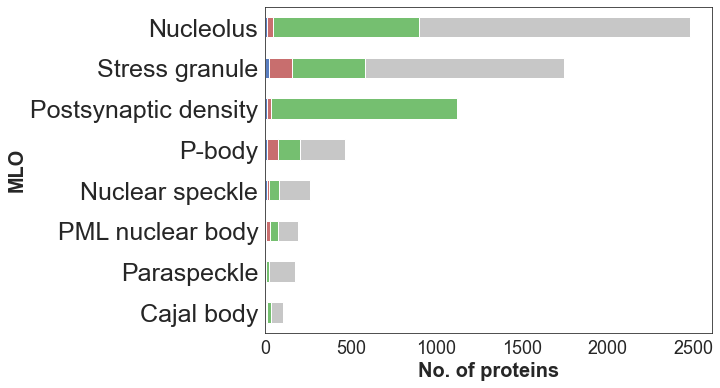

In [ ]:
sns.set_style("white")
#fig, ax = plt.subplots(figsize=(12,10))
colors = ["#597dbf", "#c86e6e","#75bf70", '#c7c7c7']
stacked_sub.plot.barh(stacked=True, figsize=(8,6), color = colors)
#stacked[:20].plot(kind='bar', stacked=True)
plt.tick_params(labelsize= 18)
#plt.title("Proteins by role and MLO\n", fontsize=25, weight='bold')
plt.xlabel("No. of proteins", fontsize=20, weight='bold')
plt.ylabel("MLO", fontsize=20, weight='bold')
plt.yticks(size=25)
plt.legend().remove()

#plt.savefig('../plots/dublin_22/protein_roles_mlos.png', dpi= 300, bbox_inches = "tight")
#plt.show()

# MLOs

In [ ]:
# Frequency distribution plot
mlo_protein = protein_has_mlo.groupby('mlo')['id_protein'].count().sort_values(ascending = False)
mlo_protein

mlo
Nucleolus                                         3315
Stress granule                                    2529
Postsynaptic density                              1388
P-body                                             818
Centrosome/Spindle pole body                       534
                                                  ... 
collagen-containing extracellular matrix             1
condensed compartments of microtubule bundling       1
cytoplasmic microtubule                              1
euchromatin                                          1
synaptosome                                          1
Name: id_protein, Length: 103, dtype: int64

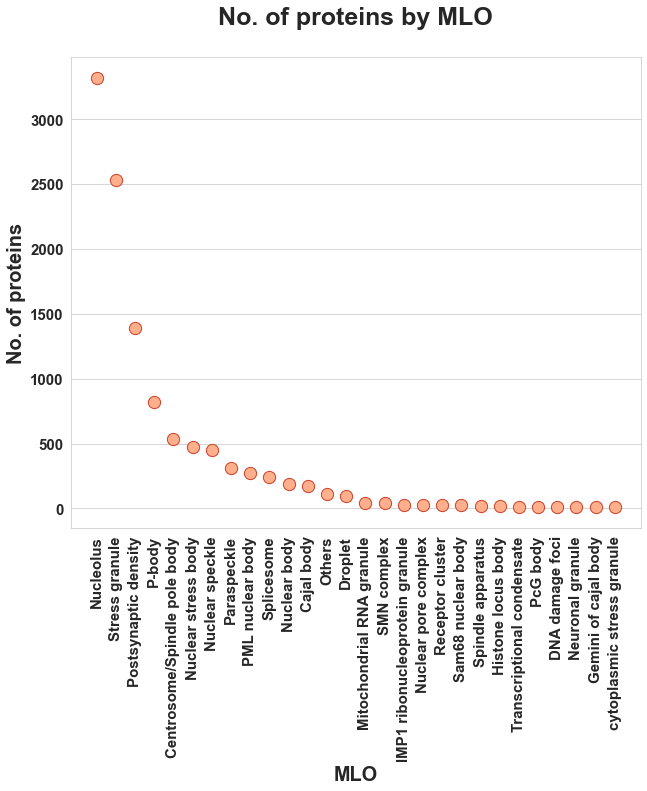

In [ ]:
# MLOs con > 10 proteinas asociadas
# https://color.adobe.com/es/search?q=salmon
sns.set_style("whitegrid")
#sns.set_palette("Accent")
bar, ax = plt.subplots(figsize=(10,12))
ax = sns.scatterplot(x= mlo_protein[mlo_protein >= 10].index, y= mlo_protein[mlo_protein >= 10], s= 150, color= '#FFAF8C', edgecolor= '#CC4128', linewidth=1)
ax.tick_params(labelsize=15)
ax.tick_params(axis='x', labelrotation= 90)
ax.grid(axis="x")
ax.set_title("No. of proteins by MLO\n", fontsize=25, weight='bold')
ax.set_ylabel ("No. of proteins", fontsize=20, weight='bold')
ax.set_xlabel ("MLO", fontsize=20, weight='bold')
plt.tight_layout()
plt.show()
bar.savefig("../plots/dublin_22/proteins_mlos.png", dpi= 300, bbox_inches='tight')

In [ ]:
proteinsbymlo = protein_has_mlo[['id_protein', 'mlo']].drop_duplicates() # drop duplicates para no repetir pares proteina-MLO
proteinsbymlo = proteinsbymlo.id_protein.value_counts()
proteinsbymlo
# Add protein names
proteinsbymlo_df = proteinsbymlo.to_frame('mlo_counts').join(protein.set_index('id_protein')) #'mlo_counts' nombre de la col cdo se pasa de Series a df
proteinsbymlo_df
# La mayoria estan asociadas a un MLO
mlo_frequency = proteinsbymlo_df.mlo_counts.value_counts().to_frame()
mlo_frequency

,mlo_counts
1,3729
2,1242
3,429
4,167
5,81
6,34
7,29
8,11
9,8
10,4


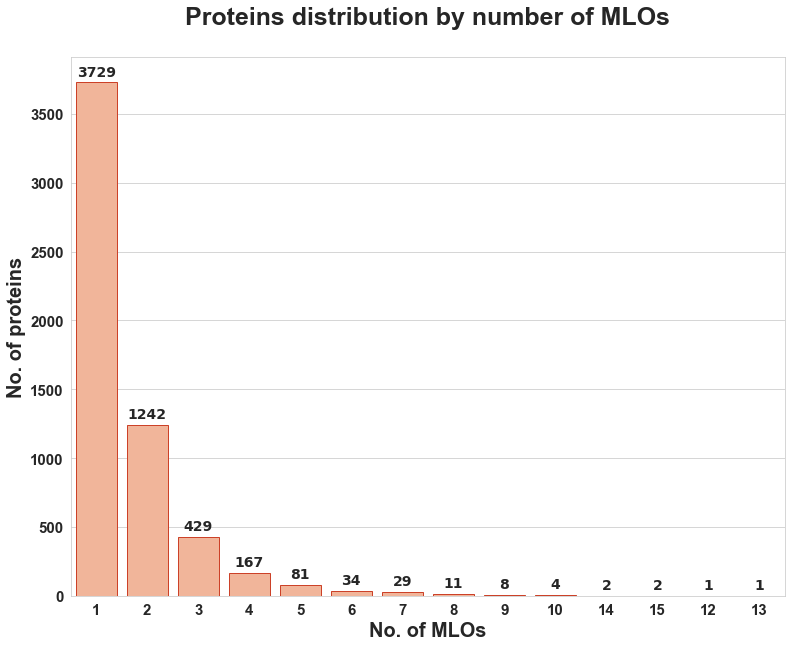

In [ ]:
sns.set_style("whitegrid")
bar, ax = plt.subplots(figsize=(12,10))
ax = sns.barplot(x= mlo_frequency.index, y= mlo_frequency.mlo_counts, color= '#FFAF8C', edgecolor= '#CC4128', linewidth=1)
ax.tick_params(labelsize=15)
ax.set_xlim(-.5, 13.5)
ax.set_title("Proteins distribution by number of MLOs\n", fontsize=25, weight='bold')
ax.set_ylabel ("No. of proteins", fontsize=20, weight='bold')
ax.set_xlabel ("No. of MLOs", fontsize=20, weight='bold')

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 40}

matplotlib.rc('font', **font)
ax.set_xticklabels(mlo_frequency.index)

for i, y in enumerate(mlo_frequency.mlo_counts):
    ax.text(i, y+50, str(y), weight='bold', fontsize=14, horizontalalignment='center')

plt.tight_layout()
plt.show()
bar.savefig("../plots/dublin_22/no_proteins_no_mlo.png", dpi=300)

In [ ]:
mutation = pd.read_csv('../db_tables/mutation_new.tsv.gz', compression= 'gzip', sep= '\t')

C:\Users\User\AppData\Roaming\Python\Python37\site-packages\IPython\core\interactiveshell.py:3170: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
mutation[['id_mutation', 'id_protein']].duplicated().any()

False

In [ ]:
# How many LLPS proteins are in MLOs
protein_has_mlo.id_protein.nunique() # 5740, all of them

5740

In [ ]:
mlosmetadb = pd.read_csv("../raw_data/mlosmetadb_dataset.csv")
mlosmetadb.shape

(12038, 11)

In [ ]:
organisms = mlosmetadb.Organism.value_counts()
organisms

Homo sapiens                5761
Arabidopsis thaliana        1955
Mus musculus                1943
Saccharomyces cerevisiae     796
Caenorhabditis elegans       422
                            ... 
Gorilla gorilla gorilla        1
Branchiostoma floridae         1
Pinctada fucata                1
Aedes aegypti                  1
Escherichia coli O70:NM        1
Name: Organism, Length: 106, dtype: int64

In [ ]:
organisms[organisms > 10].shape

(15,)

---

In [ ]:
protein_has_mlo[['id_protein', 'rol']].drop_duplicates()#.fillna("unassigned").rol.value_counts(dropna= False)

,id_protein,rol
0,1,driver
10,1,unassigned
21,2,driver
22,2,unassigned
41,3,driver
...,...,...
11513,5738,unassigned
11514,5739,unassigned
11515,5740,unassigned
11517,5741,client


In [ ]:
__ = protein_has_mlo[['id_protein', 'rol']].drop_duplicates()
__

,id_protein,rol
0,1,driver
10,1,unassigned
21,2,driver
22,2,unassigned
41,3,driver
...,...,...
11513,5738,unassigned
11514,5739,unassigned
11515,5740,unassigned
11517,5741,client


In [ ]:
driver = __[__.rol == 'driver'].id_protein.to_list()
client = __[__.rol == 'client'].id_protein.to_list()
regulator = __[__.rol == 'regulator'].id_protein.to_list()

In [ ]:
output_file = open('drivers.txt', 'w')

for d in driver:
    output_file.write(str(d)+'\n')

output_file.close()

In [ ]:
output_file = open('clients.txt', 'w')

for d in client:
    output_file.write(str(d)+'\n')

output_file.close()

In [ ]:
output_file = open('regulators.txt', 'w')

for d in regulator:
    output_file.write(str(d)+'\n')

output_file.close()